In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
from copy import deepcopy as dc
import sklearn

import torch
import torch.nn as nn

In [3]:
df = pd.read_csv('AMZN.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1,1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
2,1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000
3,1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
4,1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000
...,...,...,...,...,...,...,...
6511,2023-03-30,101.550003,103.040001,101.010002,102.000000,102.000000,53633400
6512,2023-03-31,102.160004,103.489998,101.949997,103.290001,103.290001,56704300
6513,2023-04-03,102.300003,103.290001,101.430000,102.410004,102.410004,41135700
6514,2023-04-04,102.750000,104.199997,102.110001,103.949997,103.949997,48662500


In [4]:
df = df[['Date', 'Close']]
df

,Date,Close
0,1997-05-15,0.097917
1,1997-05-16,0.086458
2,1997-05-19,0.085417
3,1997-05-20,0.081771
4,1997-05-21,0.071354
...,...,...
6511,2023-03-30,102.000000
6512,2023-03-31,103.290001
6513,2023-04-03,102.410004
6514,2023-04-04,103.949997


/var/folders/8c/mqvx3lqn6m513h1007r856ch0000gn/T/ipykernel_57943/2968222602.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'])


Text(0, 0.5, 'Price')

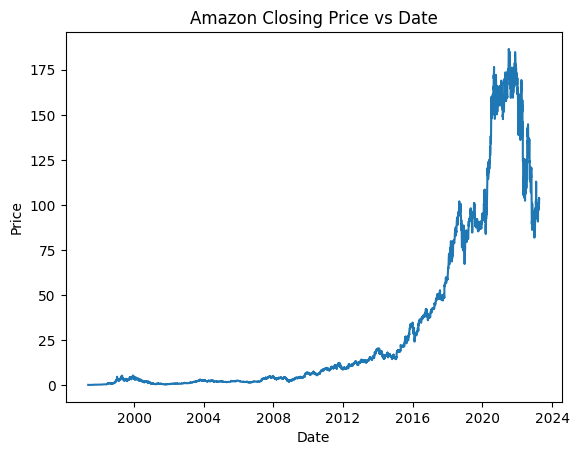

In [6]:
df['Date'] = pd.to_datetime(df['Date'])
plt.plot(df['Date'], df['Close'])
plt.title('Amazon Closing Price vs Date')
plt.xlabel('Date')
plt.ylabel('Price')


In [11]:
# prepare data for lstm

def lstm_add_lags(df, n_steps): # add a weeks worth lag
    df = dc(df)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)
    df.dropna(inplace=True)
    return df

lookback = 7
shifted_df = lstm_add_lags(df, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
1997-05-27,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458,0.097917
1997-05-28,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458
1997-05-29,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417
1997-05-30,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771
1997-06-02,0.075521,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354
...,...,...,...,...,...,...,...,...
2023-03-30,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999,98.699997,100.610001
2023-03-31,103.290001,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999,98.699997
2023-04-03,102.410004,103.290001,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999


In [13]:
shifted_df_to_numpy = np.array(shifted_df)
shifted_df_to_numpy

array([[7.91670000e-02, 7.50000000e-02, 6.97920000e-02, ...,
        8.54170000e-02, 8.64580000e-02, 9.79170000e-02],
       [7.65630000e-02, 7.91670000e-02, 7.50000000e-02, ...,
        8.17710000e-02, 8.54170000e-02, 8.64580000e-02],
       [7.52600000e-02, 7.65630000e-02, 7.91670000e-02, ...,
        7.13540000e-02, 8.17710000e-02, 8.54170000e-02],
       ...,
       [1.02410004e+02, 1.03290001e+02, 1.02000000e+02, ...,
        9.80400010e+01, 9.81299970e+01, 9.87099990e+01],
       [1.03949997e+02, 1.02410004e+02, 1.03290001e+02, ...,
        9.72399980e+01, 9.80400010e+01, 9.81299970e+01],
       [1.01099998e+02, 1.03949997e+02, 1.02410004e+02, ...,
        1.00250000e+02, 9.72399980e+01, 9.80400010e+01]])

In [27]:
# Scaling the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_to_numpy = scaler.fit_transform(shifted_df_to_numpy)

In [32]:
X, y = shifted_df_to_numpy[:, 1:], shifted_df_to_numpy[:, 0]
X.shape, y.shape

((6509, 7), (6509,))

In [33]:
X = dc(np.flip(X, axis=1))

In [34]:
# split data, 95-5
split = int(len(X)*0.95)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6183, 7), (326, 7), (6183,), (326,))

In [36]:
# lstm's want one more col (3D data)
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))
y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6183, 7, 1), (326, 7, 1), (6183, 1), (326, 1))

In [37]:
# we're using pytorch so let's make these np arrays to pytorch tensors
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([6183, 7, 1]),
 torch.Size([326, 7, 1]),
 torch.Size([6183, 1]),
 torch.Size([326, 1]))

In [38]:
# use datasets to train models in pytorch, not just raw tensors
# so we are making dataset objects rn 

# THIS IS HOW TO MAKE A DATASET WITH PYTORCH
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y) -> None:
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [39]:
# Now we have to split the data into batches
# we do this in pytorch using DATALOADERS
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [50]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_stacked_layers,
            batch_first=True # order of data has batch size first
        )
        self.fc = nn.Linear(hidden_size, 1) # one fully connected layer
    
    def forward(self, x):
        batch_size = x.size(0)
        # pytorch needs this to build an lstm for some reason
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1) # 4 hidden layers, 1 lstm

In [54]:
learning_rate = 0.001
num_epochs = 10
epoch = 0
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def train_one_epoch():
    model.train(True) 
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0], batch[1]

        output = model(x_batch)
        loss = loss_function(output, y_batch) # comparing output to ground truth
        running_loss += loss.item() # using .item because loss is a tensor

        optimizer.zero_grad() # clear previous gradients
        loss.backward() # calculate gradient
        optimizer.step() # take a step towards gradient

        # print avg loss every hundred batches
        if batch_index % 100 == 99:
            avg_loss = running_loss/100
            print(f'Batch {batch_index+1}, loss: {avg_loss}')
            running_loss = 0.0
    print()

In [56]:
def test_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0], batch[1]

        with torch.no_grad(): # to not calculate gradient
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item( )
        
    avg_loss = running_loss/len(test_loader)
    print(f'Val loss: {avg_loss}')
    print('***********************************************************')
    print()

In [57]:
learning_rate = 0.001
num_epochs = 10

for epoch in range(num_epochs):
    train_one_epoch()
    test_one_epoch()

Epoch: 1
Batch 100, loss: 0.00913955019612331
Batch 200, loss: 0.007325774251658004
Batch 300, loss: 0.0039860013371799145

Val loss: 0.009761405665250052
***********************************************************

Epoch: 2
Batch 100, loss: 0.001610706168867182
Batch 200, loss: 0.0011489236252964475
Batch 300, loss: 0.0006774415329709882

Val loss: 0.005180442481235202
***********************************************************

Epoch: 3
Batch 100, loss: 0.0003982434995123185
Batch 200, loss: 0.00030756583922993743
Batch 300, loss: 0.0003430044638662366

Val loss: 0.00364809591112481
***********************************************************

Epoch: 4
Batch 100, loss: 0.00023349406181750966
Batch 200, loss: 0.00021280926043800718
Batch 300, loss: 0.00023095080245184364

Val loss: 0.003832855145446956
***********************************************************

Epoch: 5
Batch 100, loss: 0.0002468548717070007
Batch 200, loss: 0.00021056975761212014
Batch 300, loss: 0.000176058007850770

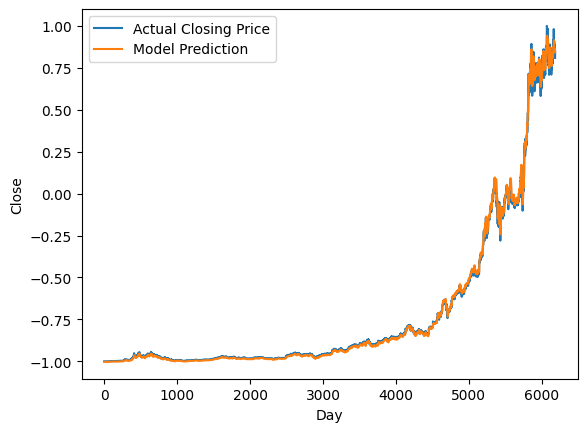

In [61]:
with torch.no_grad():
    predicted = model(X_train).numpy()

plt.plot(y_train,label='Actual Closing Price')
plt.plot(predicted, label='Model Prediction')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()